## 任务说明

- 论文作者统计，统计所有论文作者出现评率Top10的姓名；

### 数据处理步骤

在原始arxiv数据集中论文作者`authors`字段是一个字符串格式，其中每个作者使用逗号进行分隔分，所以我们我们首先需要完成以下步骤：

- 使用逗号对作者进行切分；
- 剔除单个作者中非常规的字符；

当然在原始数据集中`authors_parsed`字段已经帮我们处理好了作者信息，可以直接使用该字段完成后续统计。

## 任务实现

### 导入库

In [59]:
#>==============示例代码==============<
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具
#>================cHEn================<
import sys
import numpy as np

### 读入数据

In [2]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 
                                 'doi','report-no', 'categories', 'license', 'abstract', 'versions',
                                 'update_date', 'authors_parsed'], count=None, toDf=False):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
        toDf: 是否转为DataFrame的格式
    '''
    
    data = []
    with open(path,'r') as f:
        for idx, line in enumerate(f):
            if idx == None:
                break
            
            d = json.loads(line)  # 注意load和loads是两个不一样的函数
            d = {col : d[col] for col in columns}
            data.append(d)
            
    if toDf:# 因为或许需要测试，添加了可选项是否转为DataFrame的格式
        return pd.DataFrame(data)
    else:
        return data

尝试自己编写代码实现这个功能，发现看懂和会写直接还是有差距

In [3]:
data = readArxivFile('../arxiv-metadata-oai-snapshot.json', 
                     ['id', 'authors', 'categories', 'authors_parsed'],
                    100000)
data = pd.DataFrame(data)

In [18]:
data.head()

,id,authors,categories,authors_parsed
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",hep-ph,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Ileana Streinu and Louis Theran,math.CO cs.CG,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,physics.gen-ph,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,math.CO,"[[Callan, David, ]]"
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,math.CA math.FA,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


### 数据统计
接下来我们将完成以下统计操作：

- 统计所有作者姓名出现频率的Top10；
- 统计所有作者姓（姓名最后一个单词）的出现频率的Top10；
- 统计所有作者姓第一个字符的评率；

为了节约计算时间，下面选择部分类别下的论文进行处理：

#### 选择类别为cs.CV下面的论文

In [16]:
# 法1：利用apply进行字符串操作
data_cv = data[data['categories'].apply(lambda x: 'cs.CV' in x)].reset_index(drop=True)

# 法2：使用Series的字符串操作
data_cv = data[data['categories'].str.contains('cs.CV')]

#### 作者拼接

In [35]:
# 法1：sum(data,[])
#>======Time:1m32s======<
all_authors_1 = sum(data_cv['authors_parsed'],[])

In [52]:
# 法2：循环
# 直接+=
all_authors_2 = []
for author in data_cv['authors_parsed'] :
    all_authors_2 += author

In [56]:
# 使用extend
all_authors_2_other = []
for author in data_cv['authors_parsed'] :
    all_authors_2_other.extend(author)

In [57]:
# 二种方式等价
all_authors_2 == all_authors_2_other

True

In [87]:
# 二者等价
all_authors_1 == all_authors_2 
# 效率上看，直接循环优于sum(list,[])，猜测是sum(list,[])的过程中大量创建了新列表元素

In [89]:
all_authors = all_authors_1

关于**sum(list,[])**:

In [44]:
test_lst = [['1-1','1-2'],['2-1',['3-1',['4-1'],'3-3'],'2-3'],['1-4']]
sum(test_lst,[])

['1-1', '1-2', '2-1', ['3-1', ['4-1'], '3-3'], '2-3', '1-4']

**发现：**这种形式只能对嵌一层的元素求和，而非把所有非列表元素加总

In [82]:
# 实现跨层拼接
test_lst = str(test_lst)
test_lst = test_lst.replace('[','')
test_lst = test_lst.replace(']','')
test_lst = test_lst.replace("'",'')
test_lst.split(',')

['1-1', ' 1-2', ' 2-1', ' 3-1', ' 4-1', ' 3-3', ' 2-3', ' 1-4']

In [91]:
# 得到所有的作者的姓名全称
authors_names = [' '.join(x) for x in all_authors]
authors_names = pd.DataFrame(authors_names)

#### 绘图

##### 根据作者频率绘制直方图

<AxesSubplot:>

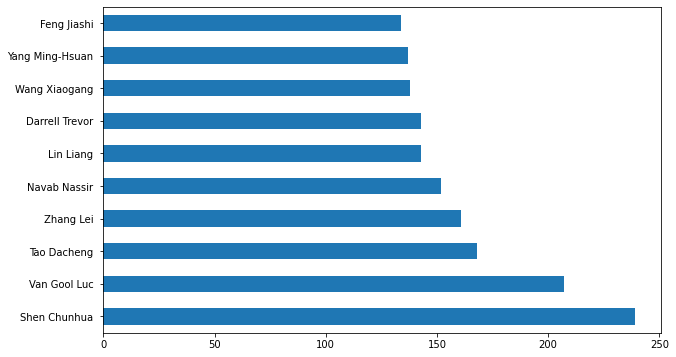

In [102]:
plt.figure(figsize=(10, 6))
authors_names[0].value_counts().head(10).plot(kind='barh')

##### 根据姓名的姓绘制直方图

Text(0.5, 0, 'Count')

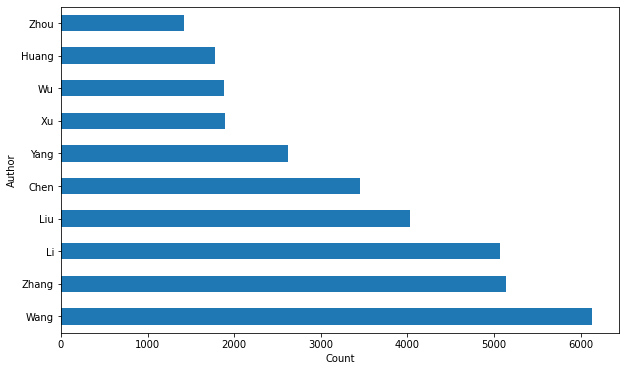

In [99]:
authors_lastnames = [name[0] for name in all_authors]
authors_lastnames = pd.DataFrame(authors_lastnames)

plt.figure(figsize=(10, 6))
authors_lastnames[0].value_counts().head(10).plot(kind='barh')

names = authors_lastnames[0].value_counts().index.values[:10]
_ = plt.yticks(range(0, len(names)), names)
plt.ylabel('Author')
plt.xlabel('Count')


相关笔记可以前往：

https://github.com/chenjiyan2001/Datawhale-2021.1-team-learning-AcademicTrends/tree/main/%E7%AC%94%E8%AE%B0